In [1]:
#Imports________________________________________________________
#System, Plotting
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml

matplotlib.rcParams.update({'text.usetex': True, 
                            'font.family': 'Computer Modern Roman'})
matplotlib.rcParams['figure.dpi'] = 300

#likelihood, mcmc packages
from classy import Class
from getdist import loadMCSamples, plots, mcsamples, MCSamples

/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Introduction

 The following notebook demonstrates the required components of my recreation of the results in [D'Amico et al. 2021](https://arxiv.org/pdf/2006.12420.pdf). I focus on how [CLASS_EDE](https://github.com/mwt5345/class_ede) and [MontePython](https://github.com/baudren/montepython_public) are used for cosmological parameter extraction, in this case using BOSS DR12 Full-shape data. "Full-Shape" refers to the full shape of the galaxy redshift space power spectra, out to large wavenumbers ($k \sim 0.25-0.3$ $h/\rm{Mpc}$). These data are predicted using the Effective Field Theory of LSS, where the power spectra can be written 

 $$ P^{\rm{EFT}}_\ell(k) = P^{\rm{lin}}_\ell(k) + P^{\rm{1-loop}}_\ell(k) + P^{\rm{ctr}}_\ell(k) + P^{\rm{stoch}}_\ell(k)$$

The cosmological parameters of interest (particularly $h$ and $f_{\rm EDE}$) enter into this model via the $P^{\rm{lin}}_\ell(k)$ term. This term is that predicted by the linear theory of perturbations in LSS, and is computed with CLASS_EDE (the Cosmic Linear Anisotropy Solving System (for Early Dark Energy)). 

The additional terms introduce nuisance parameters to be marginalized over with our MCMC sampling. These are computed with the [PyBird](https://github.com/pierrexyz/pybird) code, which interfaces with CLASS. 

# MCMC Sampling: Montepython

The MontePython package can be used for MCMC sampling and analysis of a variety of cosmological datasets (e.g. Planck, Pantheon, BOSS, etc.) I give a brief example of the inputs of a standard $\Lambda$-CDM run using the likelihood provided by PyBird at pybird/montepython/likelihoods/eftboss. 

I will start by specifing the terminal command I would use for a run:

In [2]:
! mpirun -np 5 python montepython/MontePython.py -N 100 -p input/eftboss_lcdm.param -o chains/eftboss_example02 -f 0.3

/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy

This should take ~5-7 mins to run.

First parsing through each of the commands given: 
- `mpirun -np 5` specifies the number of chains to run in parallel using mpi
- `python montepython/MontePython.py -N 100` calls Montepython, and specifies the number of steps to take. For this example, I specify 100 steps, but a actual run would have something like N~20,000.
- `-p input/eftboss_lcdm.param` specifies the input file location which is in the form of a ".param" file. This is where one can specify which parameters to vary/fix and place priors. Inspecting this file, you will notice that there are no EDE parameters present, but as long as you have CLASS_EDE installed, this can be specified as any other cosmological parameter (see input/eftboss_ede.param for an explicit example).
- `-o chains/eftboss_example02` instructs MontePython on where to place the finished chain files. MontePython will also store metadata about the run in this folder.
- `-f 0.3` sets the step size to be used for the Metropolis-Hastings algorithm that MP uses by default. This should be tuned to give an optimal acceptance rate of ~0.23-0.4. For the actual lcdm/EDE runs, I find that this is achieved with a a step size of 0.4/0.2. 

With this all given, MontePython begins sampling. The output will give information on the Likelihoods and data for each chain first. Once it has initialised succesfully, it will begin to output the likelihood value and parameters for each accepted step:

`#  -LogLkl	omega_cdm       h               ln10^{10}A_s    b1_hN           c2_hN           b1_hS           c2_hS           b1_lN           c2_lN           b1_lS         c2_lS           Omega_m         1e+09A_s        sigma8          rs_rec          da_rec          
1  338.557	1.198690e-01	6.821458e-01	3.044324e+00	2.000000e+00	0.000000e+00	2.000000e+00	0.000000e+00	2.000000e+00	0.000000e+00	2.000000e+00	0.000000e+00	3.077285e-01	2.099583e+00	8.099110e-01	1.443136e+02	1.269482e+01	
1  258.598	1.169055e-01	6.733221e-01	3.029836e+00	2.000000e+00	0.000000e+00	2.000000e+00	0.000000e+00	2.000000e+00	0.000000e+00	2.000000e+00	0....` 

Once the steps are completed, Montepython will state the acceptance rate for the run (again, for each chain):

`#  100 steps done, acceptance rate: 0.26`

Now we can move on to analyzing the chains, which can be done with the command:

In [3]:
! python montepython/MontePython.py info chains/eftboss_example02

/home/cosweeney/miniconda3/envs/pyb2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.0

--> Scanning file chains/eftboss_example02/2023-12-13_100__1.txt: Removed everything: chain not converged
                                           2023-12-13_100__2.txt: Removed everything: chain not converged
                                           2023-12-13_100__3.txt: Removed everything: chain not converged
                                           2023-12-13_100__4.txt: Removed everything: chain not converged
                                           2023-12-13_100__5.txt: Removed 0 non-markovian points, 20 points of burn-in, keep 7 steps
--

This will give some information about the length of the chains and the convergence of the chains using the Gelman-Rubin convergence statistic: converged chains should have $R-1 \ll 1$. Note that this example removes all of the steps taken and gives $R-1=0$ for all chains; this is simply due to the very short length of our example chains. 

We can also see that MP saves a set of plots to the chains folder, and saves the information (length, convergence, best-fit, etc.) about the run. This is all very handy for later. 

While I show how to get some example chains, for the remainder of the notebook I use the final lcdm/EDE chains I have saved at chains/eftboss_lcdm_f and chains/eftboss_ede_f. 

# Plotting: GetDist

I now move on to inspecting the desired posteriors. I generate corner plots, as the the authors of D'Amico et al. 2021 do, using the GetDist library.  

The first step is to load the chains produced by a Montepython run with GD. A succesful run of MontePython will produce a chains folder corresponding to that run, with each chain saved as a .txt file. A ".paramnames" file is also produced in the chain folder; this contains the names and LaTex labels of each parameter in the run, for quick insertion into a plot. To load the appropriate folder, we pass the appropriate root directory:

In [5]:
#Load in chains with loadMCSamples
samps = "chains/eftboss_lcdm_f/2023-12-04_20000_"
samples = loadMCSamples(samps, settings={'ignore_rows': 0.5}) #Discard 0.5 of steps as burn-in

We can do the same for the EDE run:

In [6]:
#f_ede samples 
samps2 = "chains/eftboss_ede_f/2023-12-10_20000_"
samples2 = loadMCSamples(samps2, settings={'ignore_rows': 0.5}) #Discard 0.5 of steps as burn-in

In [7]:
#make sure plots show up in the notebook
%matplotlib inline 

Now we can plot the desired 2D marginalized posteriors by simpling indicating the parameter names as they appear in the ".paramnames" file to GetDist's triangle_plot module:

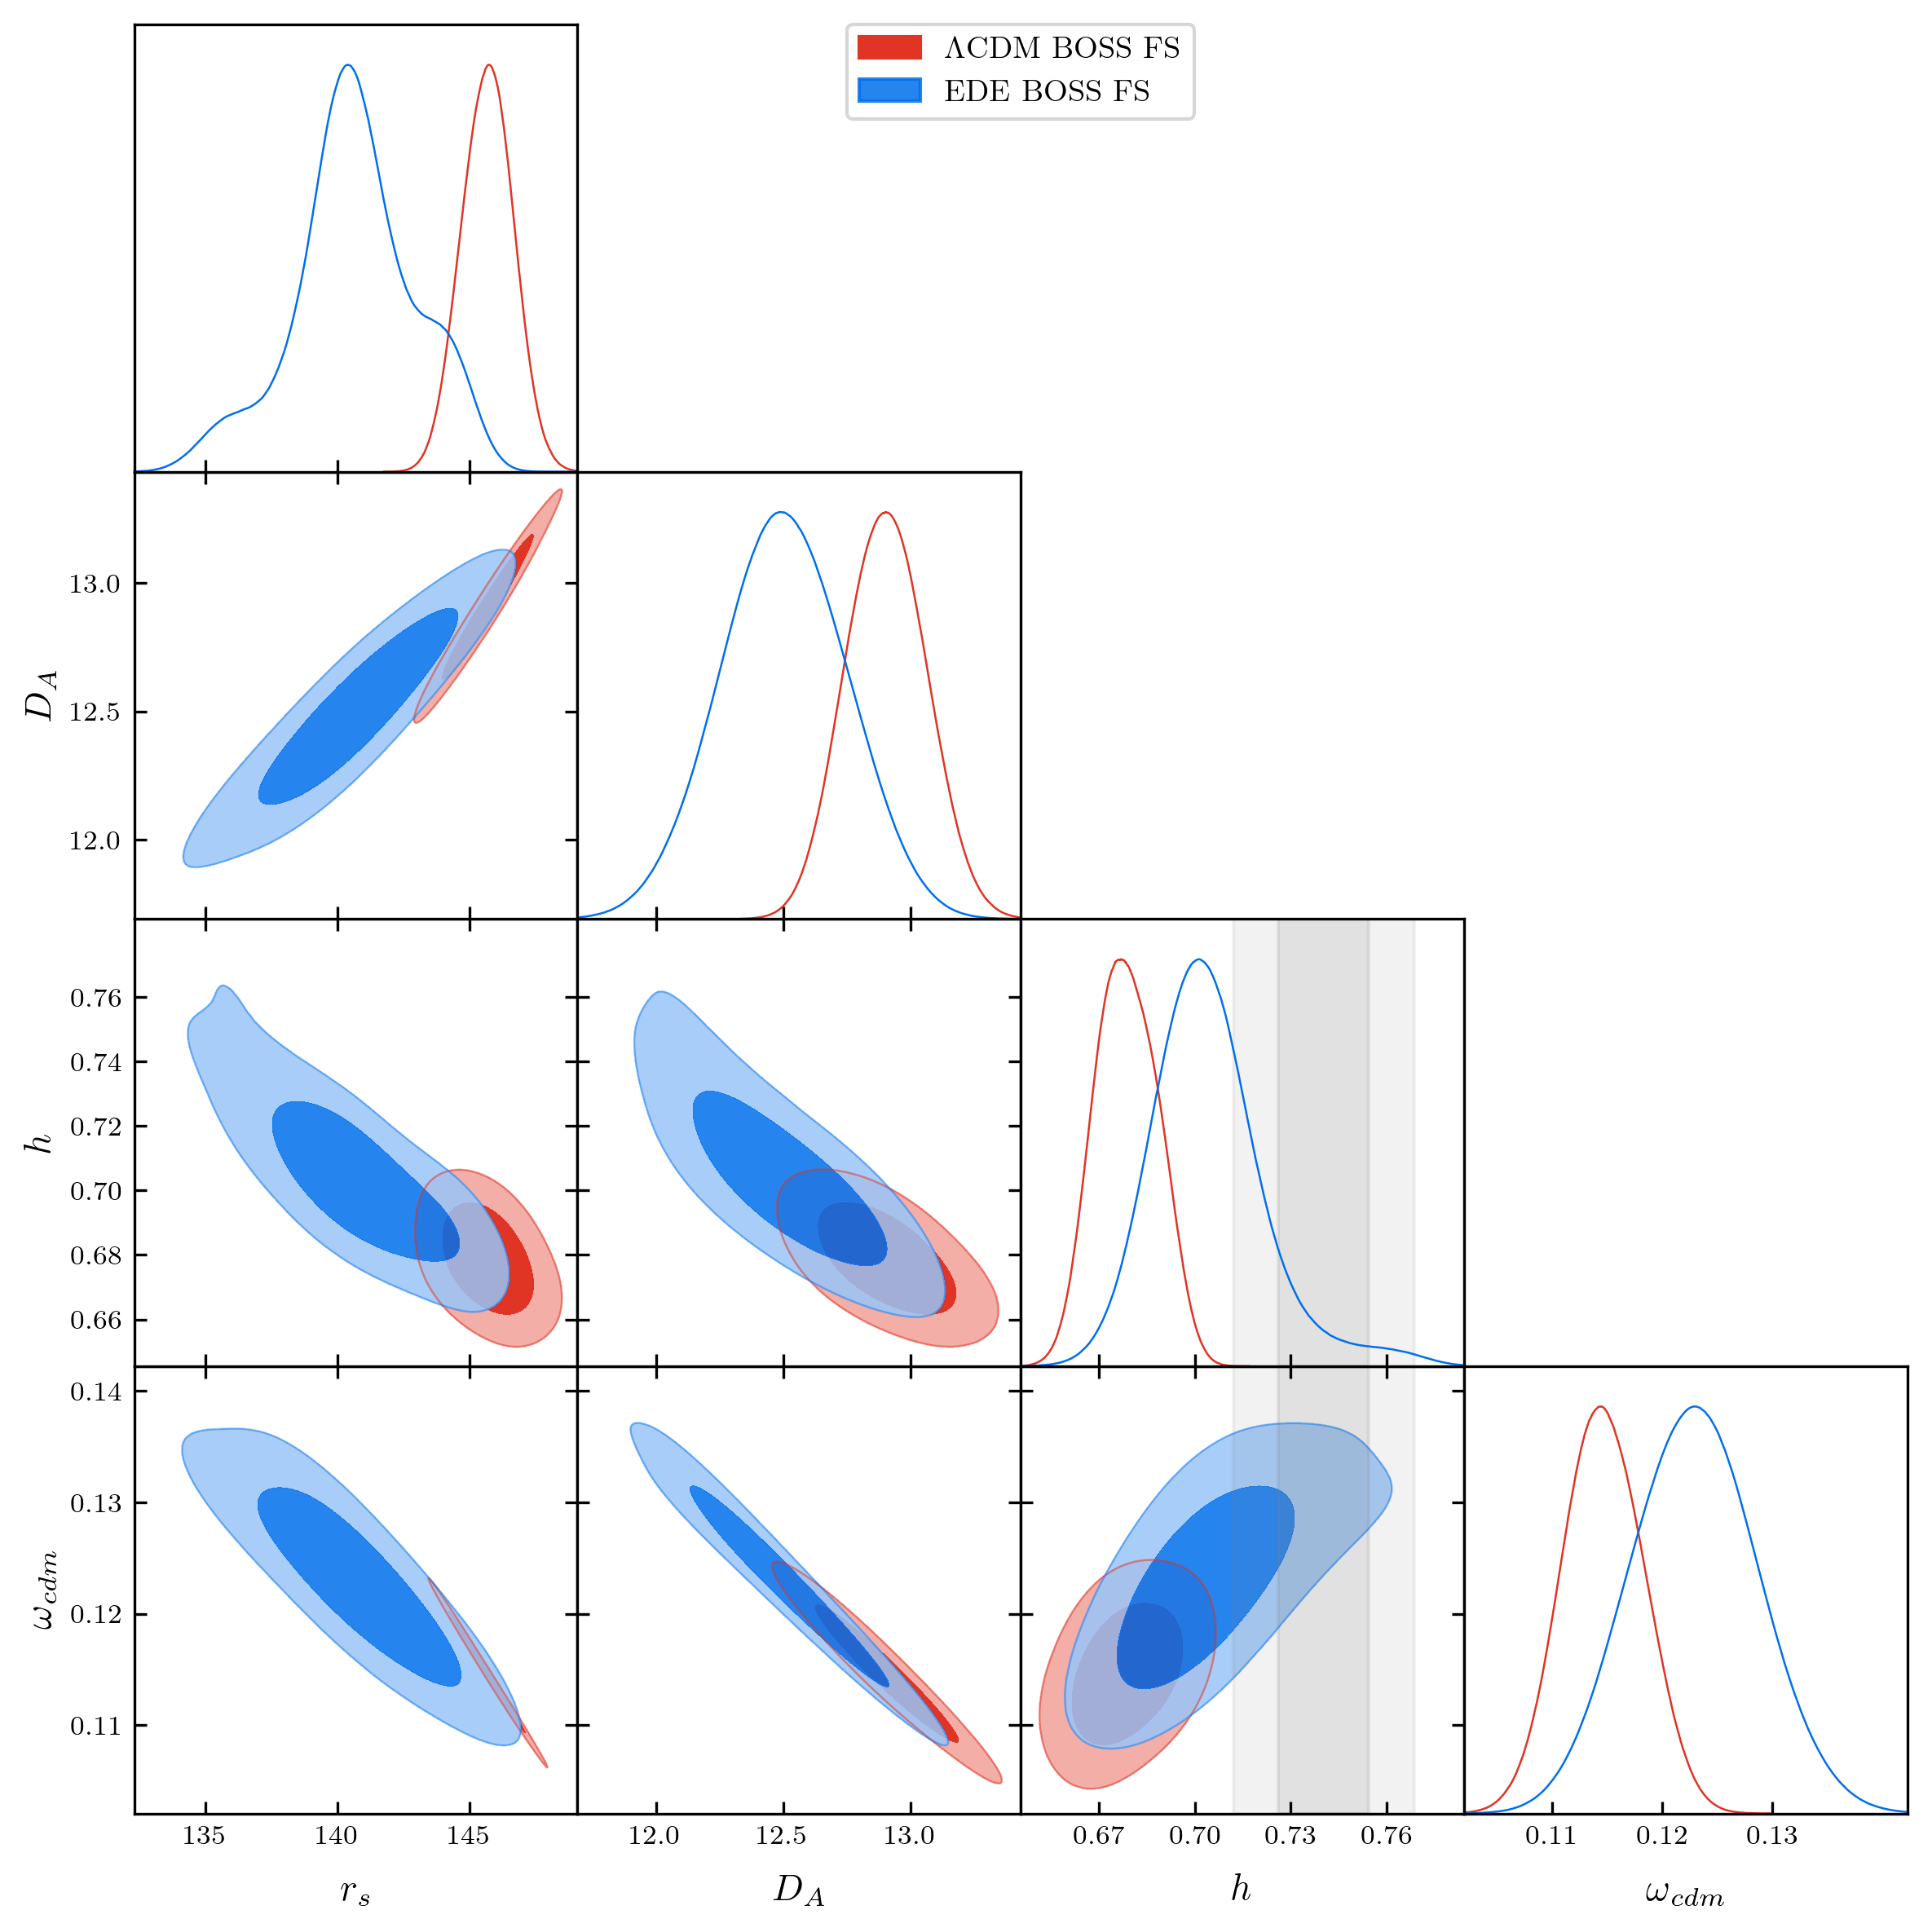

In [8]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], ['rs_rec', 'da_rec', 'h', 'omega_cdm' ], filled=True, legend_labels=[r'$\Lambda$CDM BOSS FS', r'EDE BOSS FS'])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[3,2]) #add a band indicating the SH0ES measurement of H_0
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[2,2])

Now for a plot of the common cosmological parameters between the two models:

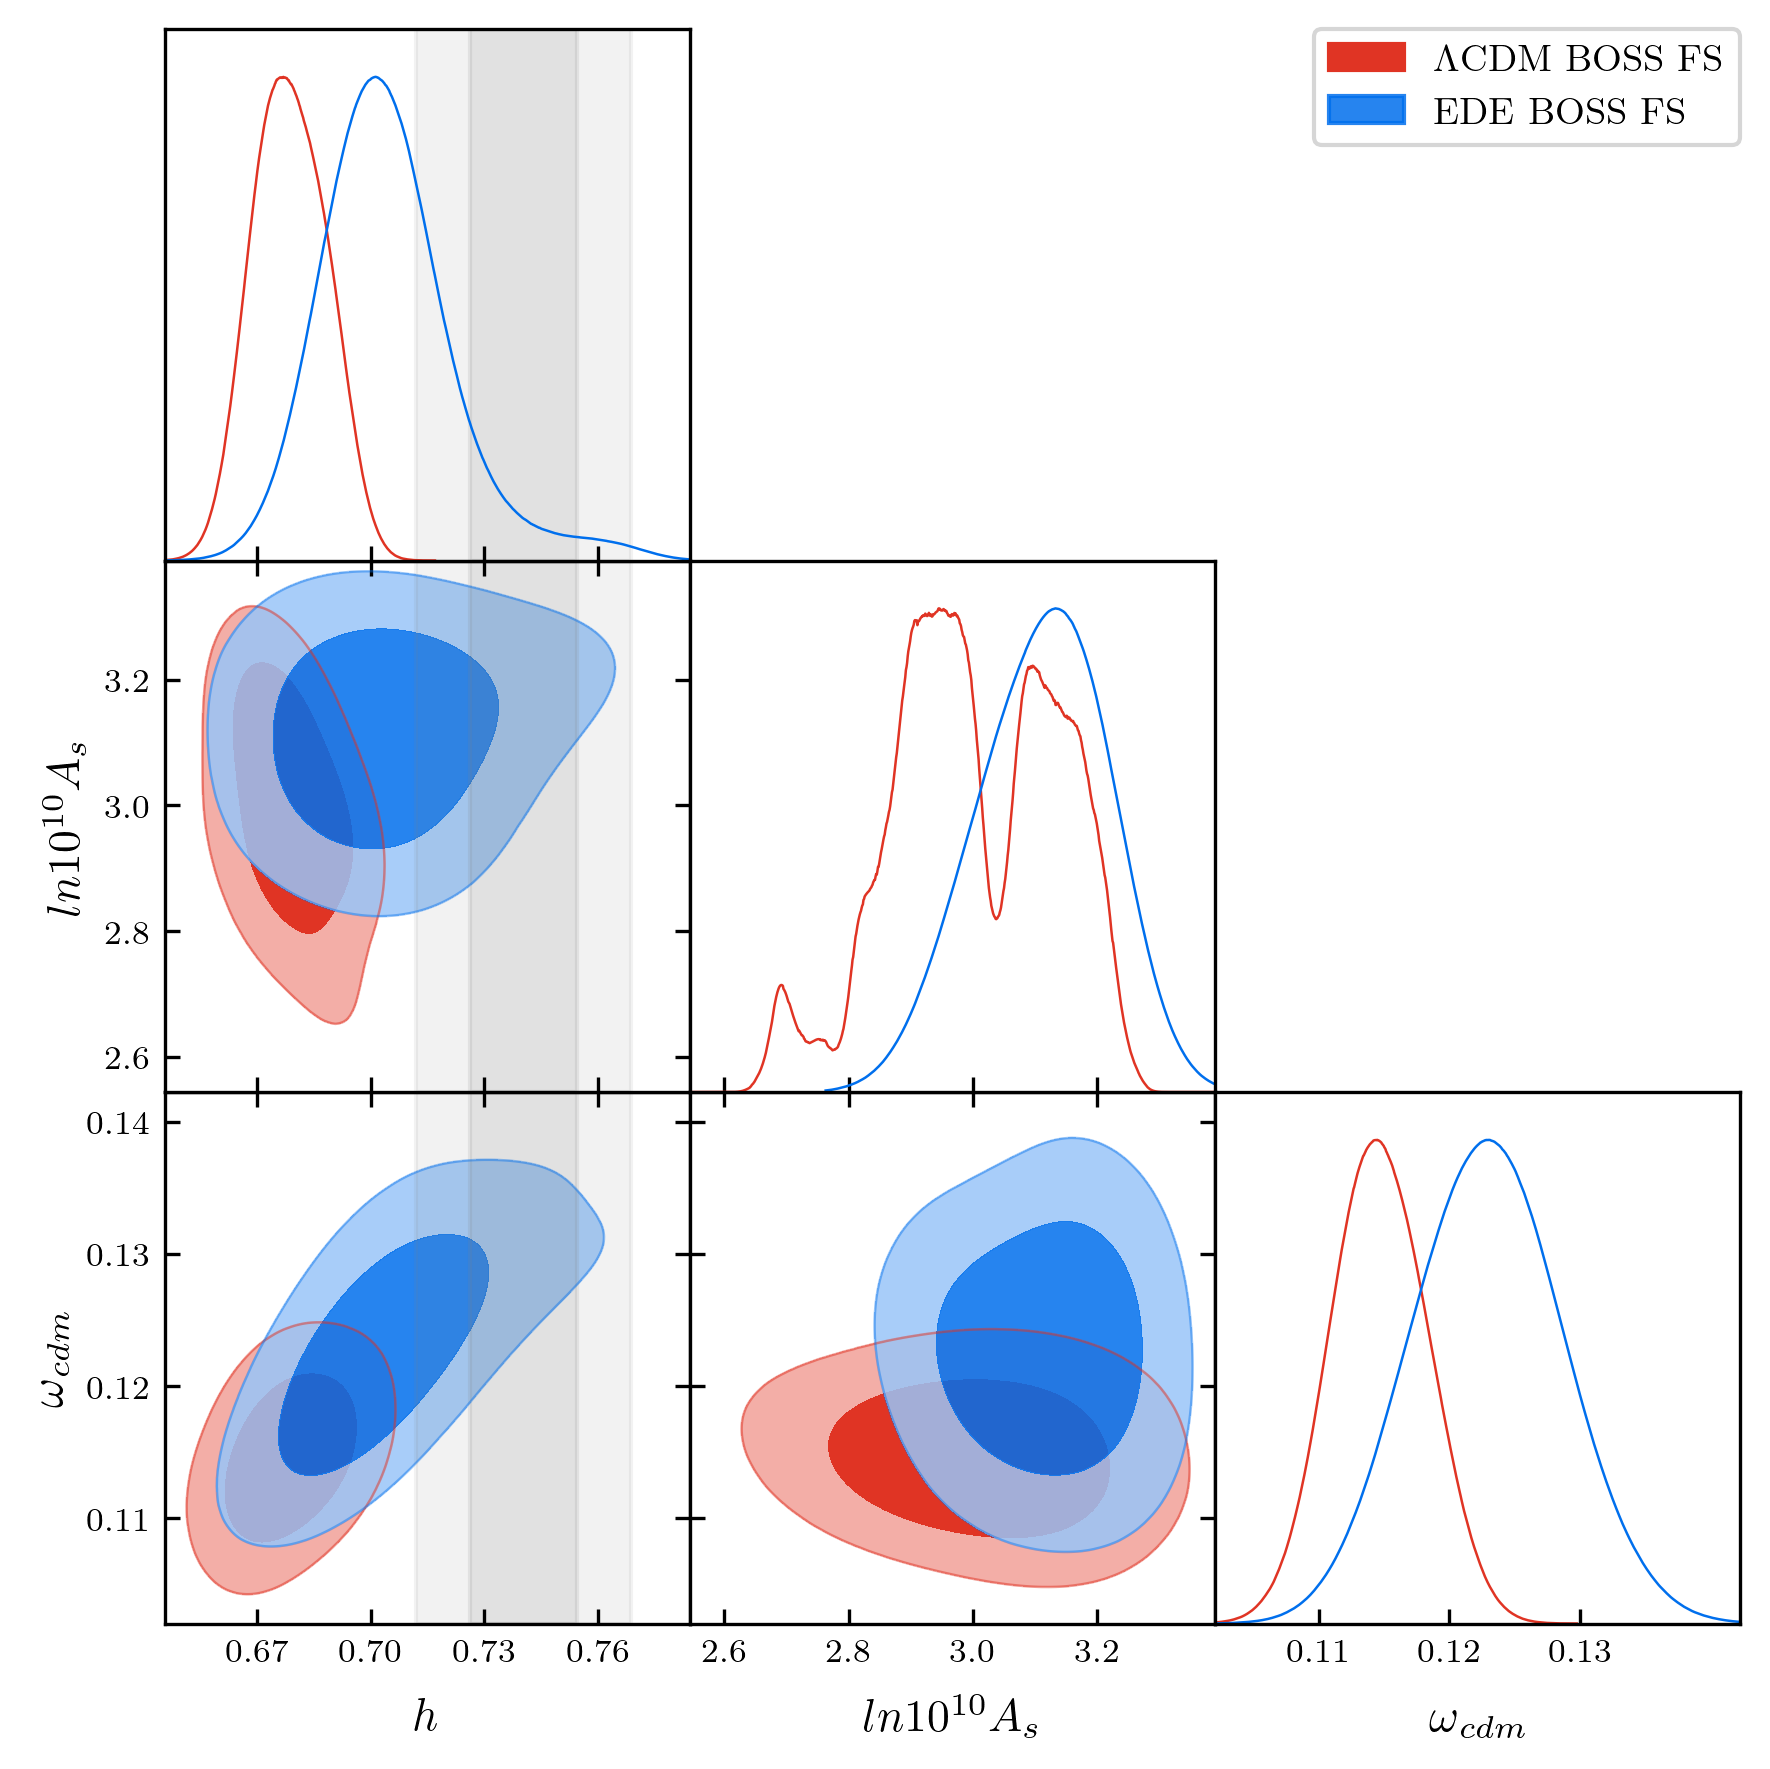

In [9]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], ['h', 'ln10^{10}A_s', 'omega_cdm' ], filled=True, legend_labels=[r'$\Lambda$CDM BOSS FS', r'EDE BOSS FS'])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[0,0]) 
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[1,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[2,0])

And finally we plot all of the cosmology parameters of the EDE model:

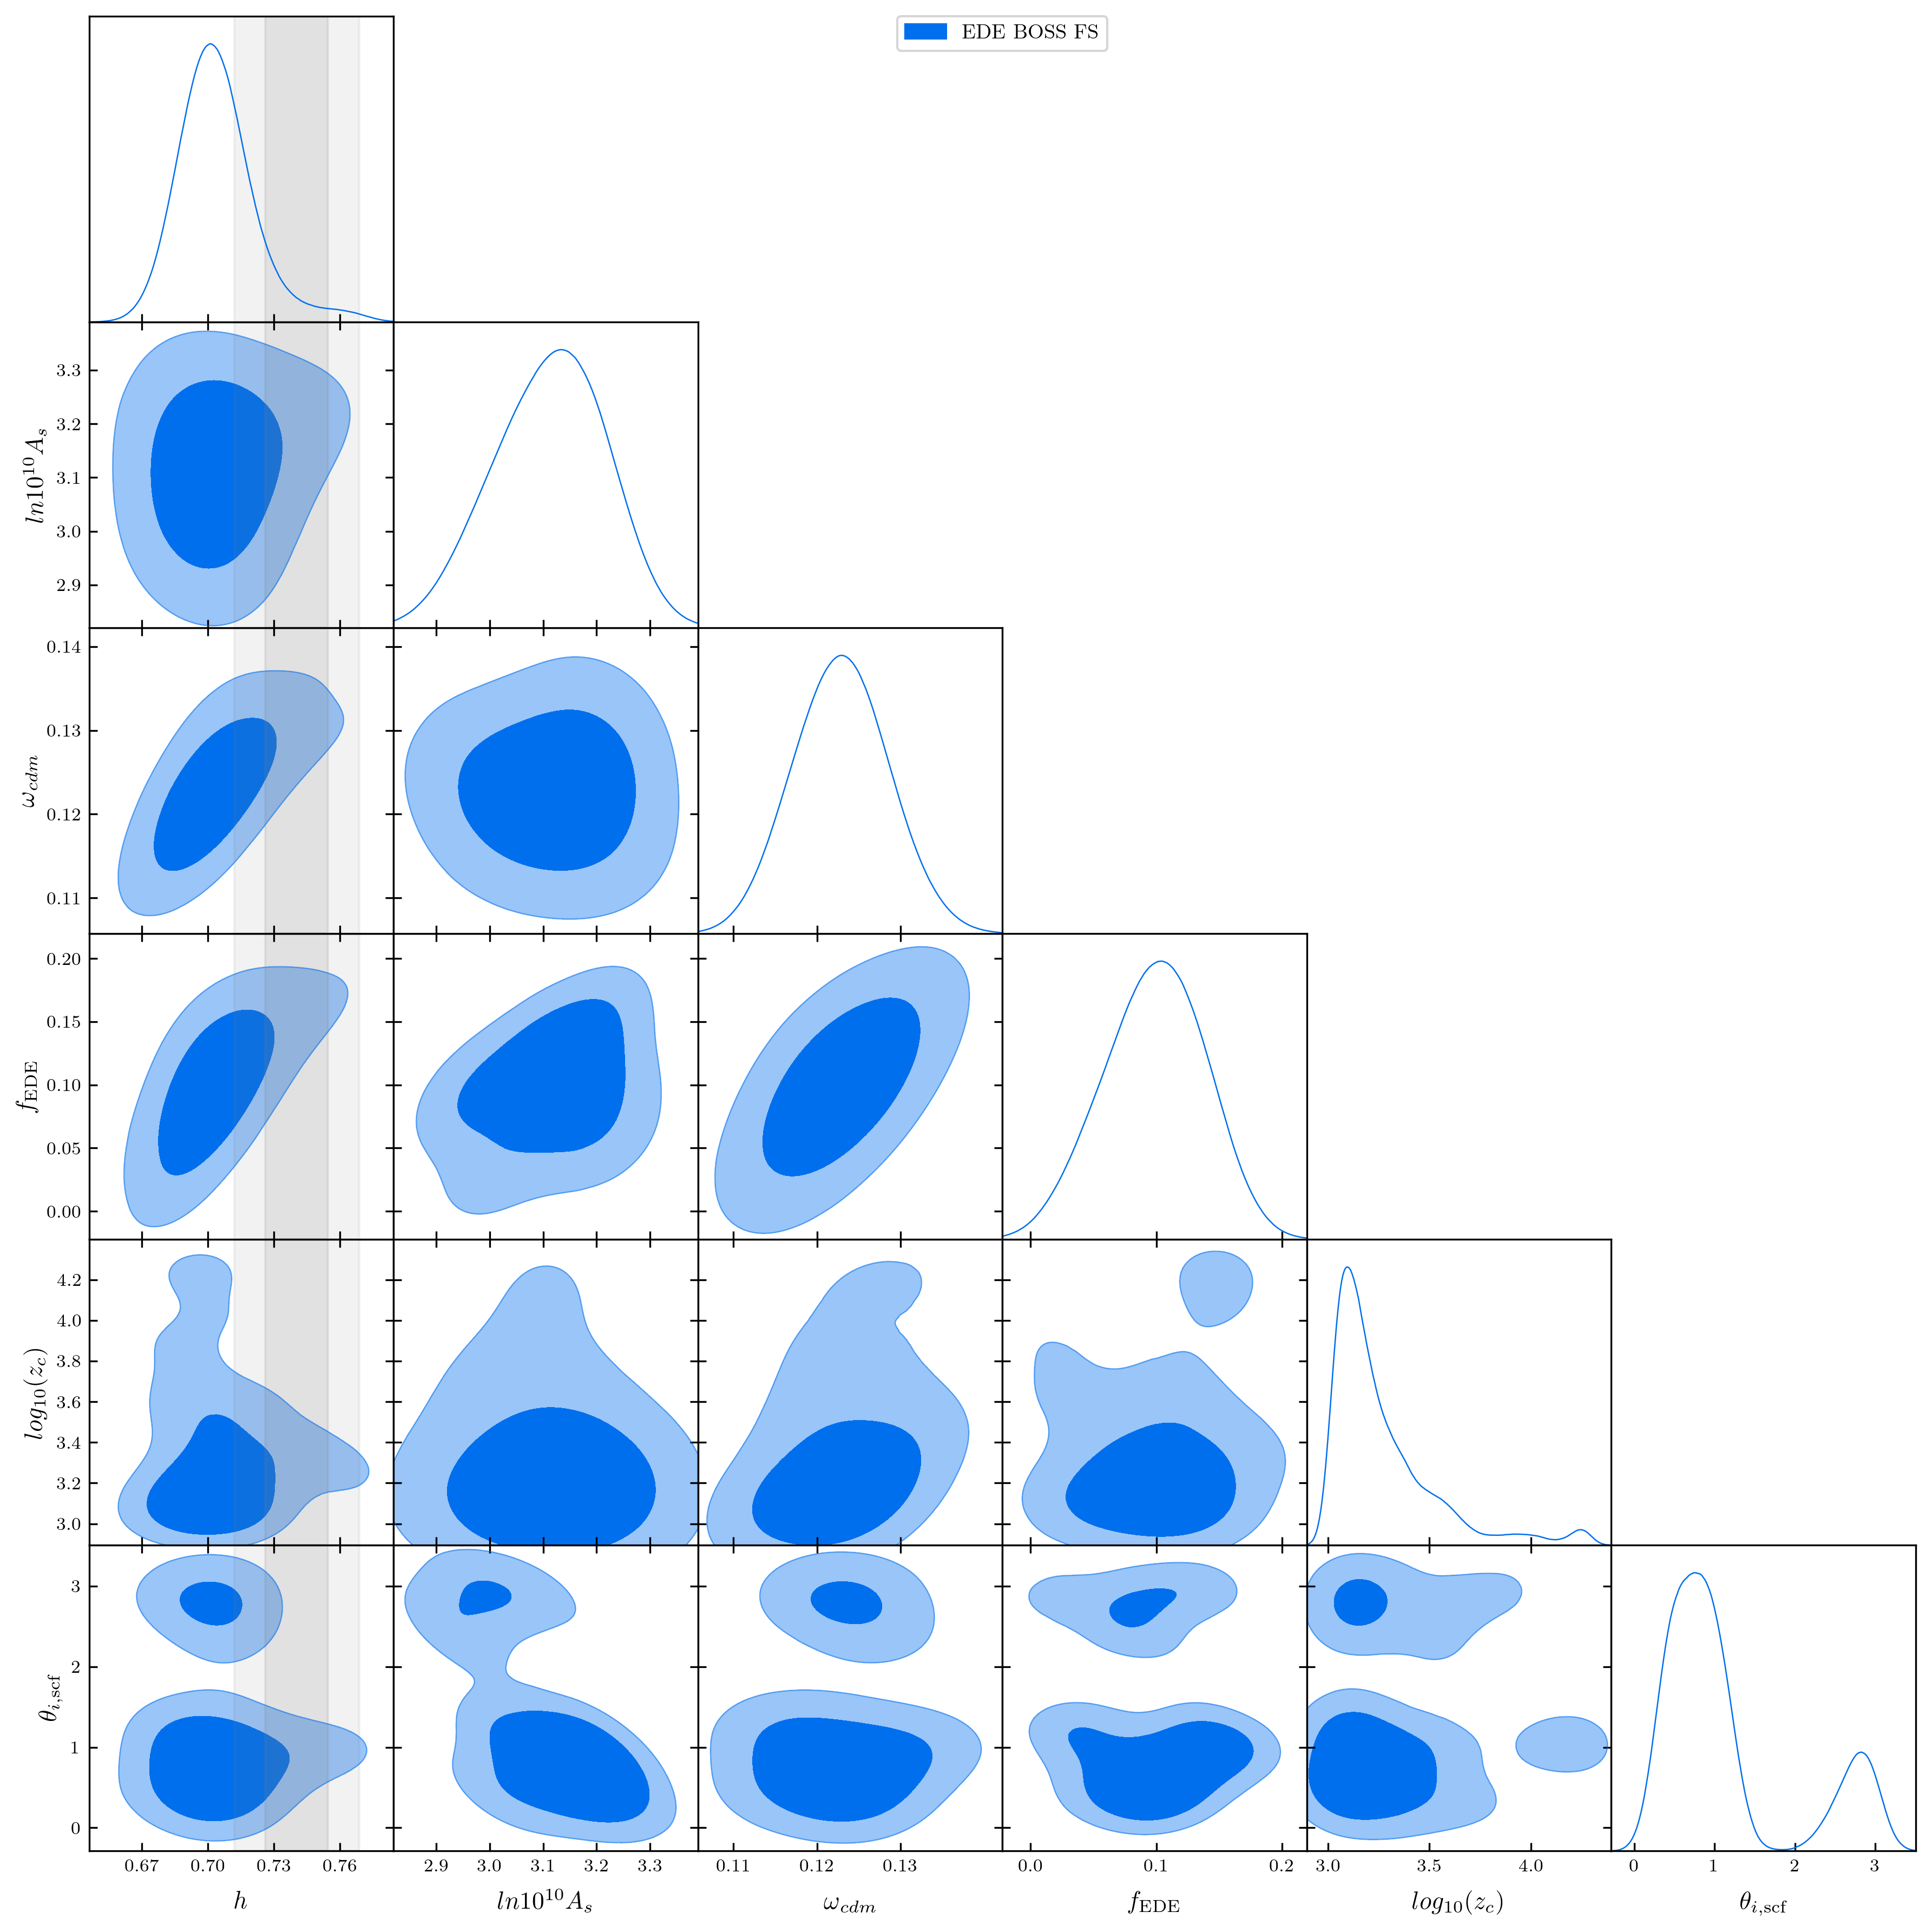

In [10]:
g = plots.get_subplot_plotter()
g.triangle_plot(samples2, ['h', 'ln10^{10}A_s', 'omega_cdm', 'fEDE', 'log10z_c', 'thetai_scf' ], filled=True, legend_labels=[r'EDE BOSS FS'])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[0,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[1,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[2,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[3,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[4,0])
g.add_x_bands(0.7403, 0.0142, ax=g.subplots[5,0])